In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel

from sklearn.decomposition import PCA
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_val_predict,
    GridSearchCV
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, classification_report, f1_score, roc_curve, auc,
    roc_auc_score, precision_recall_curve, PrecisionRecallDisplay,
    confusion_matrix
)
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

from sklearn.svm import SVC
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [2]:
df = pd.read_csv("mathe_dataset.csv", sep=";", encoding="ISO-8859-1")

In [3]:
df.head()

,Student ID,Student Country,Question ID,Type of Answer,Question Level,Topic,Subtopic,Keywords
0,647,Ireland,77,0,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
1,41,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
2,340,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
3,641,Italy,77,0,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
4,669,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."


In [4]:
df['Keywords'] = df['Keywords'].str.split(',')

In [5]:
df.head()

,Student ID,Student Country,Question ID,Type of Answer,Question Level,Topic,Subtopic,Keywords
0,647,Ireland,77,0,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
1,41,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
2,340,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
3,641,Italy,77,0,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
4,669,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."


# Classification Problem: Find whether the answer for a question is correct or not.

- Given the inputs: `Student Country, Question Level, Topic, Subtopic and Keywords`, classify whether the answer is correct.
- This is a Binary Classification problem.
- We apply different classical Machine Learning models used for Classification:
    - Logistic Regression
    - Naive Bayes
    - Support Vector Machine
    - Decision Trees
    - Random Forest Regressor
    - KNN

### Pre-processing

- Convert `Question Level, Topic and Subtopic` to one-hot-encodings using multi-label binarizer from sklearn.
- Using Tf-Idf Vectorizer, get a vector form for the Keywords. This is done in order to identify the relevance of keywords with respect to all the keywords used throughout the data.

In [6]:
multi_label_cols = ['Question Level', 'Topic', 'Subtopic', 'Student Country']
preproc_df = df.copy()

for col in multi_label_cols:
    preproc_df[col] = preproc_df[col].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(preproc_df[col])
    preproc_df = preproc_df.join(pd.DataFrame(encoded, columns=[f"{col}_{cls}".replace(" ", "_").replace(",", "_") for cls in mlb.classes_]))
    preproc_df.drop(columns=[col], inplace=True)

In [7]:
vectorizer = TfidfVectorizer(max_features=100)
preproc_df['Keywords'] = preproc_df['Keywords'].apply(lambda x: ' '.join(x))
keywords_tfidf = vectorizer.fit_transform(preproc_df['Keywords']).toarray()

In [8]:
keywords_df = pd.DataFrame(keywords_tfidf, columns=[f"keyword_{i}" for i in range(keywords_tfidf.shape[1])])
preproc_df = preproc_df.drop(columns=['Keywords']).reset_index(drop=True)
preproc_df = pd.concat([preproc_df, keywords_df], axis=1)

In [9]:
preproc_df.head()

,Student ID,Question ID,Type of Answer,Question_Level_Advanced,Question_Level_Basic,Topic_Analytic_Geometry,Topic_Complex_Numbers,Topic_Differential_Equations,Topic_Differentiation,Topic_Fundamental_Mathematics,...,keyword_90,keyword_91,keyword_92,keyword_93,keyword_94,keyword_95,keyword_96,keyword_97,keyword_98,keyword_99
0,647,77,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,41,77,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,340,77,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,641,77,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,669,77,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Performing Train-Test Splits

- Get the X (feature values) and y (target class variable)
- Split X and y using the ratio of 80:20 and a random state of 42.

In [10]:
X = preproc_df.drop(["Student ID", "Question ID", "Type of Answer"], axis=1)
y = preproc_df["Type of Answer"]

In [11]:
X.shape

(9546, 151)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Declare the classifiers to be used and, the grid of parameters to find the best performing model for each type of classifiers.

In [13]:
def get_classifiers_with_param_grids():
    classifiers = {
        "LogisticRegression": LogisticRegression(solver="liblinear"),
        "NaiveBayes": GaussianNB(),
        "DecisionTree": DecisionTreeClassifier(),
        "KNN": KNeighborsClassifier(24),
        "SVM": SVC(gamma='auto', probability=True),
        "RFC": RandomForestClassifier()
    }
    
    param_grids = {
        "LogisticRegression": {
            "C": [0.01, 0.1, 1, 10, 100],
            "penalty": ["l1", "l2"]
        },
        "NaiveBayes": {
            'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
        },
        "DecisionTree": {
            "max_depth": [None, 10, 20, 30, 40, 50],
            "min_samples_split": [2, 5, 10, 20, 30, 40, 50],
            "min_samples_leaf": [2, 5, 10, 20, 30, 40, 50],
            "criterion": ["gini", "entropy"]
        },
        "KNN": {
            "n_neighbors": list(range(1, 500, 2)),
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        },
        "SVM": {
            "C": [0.1, 1, 10, 100],
            "kernel": ["linear", "rbf"],
        },
        "RFC": {
            "n_estimators": [50, 100, 200, 300],
            "max_depth": [None, 2, 5, 10, 20, 30, 40, 50],
            "min_samples_split": [2, 5, 10, 20, 30, 40, 50],
            "min_samples_leaf": [2, 5, 10, 20, 30, 40, 50],
            "criterion": ["gini", "entropy"]
        }
    }
    return (classifiers, param_grids)

### Using GridSearchCV, optimize the results for each classifier on the basis of the best accuracy

In [14]:
classifiers, param_grids = get_classifiers_with_param_grids()
best_models = {}
best_scores = {}

for name, model in classifiers.items():
    print(f"Optimizing {name}...")
    
    search = GridSearchCV(model, param_grids[name], scoring="accuracy", n_jobs=-1)
    search.fit(X_train, y_train)

    best_models[name] = search.best_estimator_
    best_scores[name] = search.best_score_

    print(f"Best Parameters for {name}: {search.best_params_}")
    print(f"Best Model Accuracy: {search.best_score_:.4f}\n")

Optimizing LogisticRegression...
Best Parameters for LogisticRegression: {'C': 1, 'penalty': 'l1'}
Best Model Accuracy: 0.5870

Optimizing NaiveBayes...
Best Parameters for NaiveBayes: {'var_smoothing': 0.001}
Best Model Accuracy: 0.5432

Optimizing DecisionTree...
Best Parameters for DecisionTree: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 50}
Best Model Accuracy: 0.5891

Optimizing KNN...
Best Parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 139, 'weights': 'uniform'}
Best Model Accuracy: 0.5905

Optimizing SVM...
Best Parameters for SVM: {'C': 100, 'kernel': 'rbf'}
Best Model Accuracy: 0.5961

Optimizing RFC...
Best Parameters for RFC: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 50}
Best Model Accuracy: 0.5880



### Evaluation

In [28]:
def evaluate_models(best_models, X, y):
    results = []

    for name, model in best_models.items():
        y_pred = cross_val_predict(model, X, y)
        y_probs = cross_val_predict(model, X, y, method="predict_proba")[:, 1]
        
        acc = accuracy_score(y, y_pred)
        f1_weighted = f1_score(y, y_pred, average="weighted")
        f1_macro = f1_score(y, y_pred, average="macro")
        roc_auc = roc_auc_score(y, y_probs)

        results.append({
            "Classifier": name, 
            "Accuracy": acc, 
            "F1_Weighted": f1_weighted, 
            "F1_Macro": f1_macro,
            "ROC_AUC": roc_auc
        })
    
    df_results = pd.DataFrame(results)
    print(df_results)

In [16]:
evaluate_models(best_models, X_test, y_test)

           Classifier  Accuracy  F1_Weighted  F1_Macro   ROC_AUC
0  LogisticRegression  0.556545     0.545817  0.541767  0.556929
1          NaiveBayes  0.527225     0.525817  0.523842  0.531643
2        DecisionTree  0.553403     0.546093  0.542640  0.563094
3                 KNN  0.539267     0.504126  0.496945  0.536888
4                 SVM  0.553403     0.544364  0.540588  0.565349
5                 RFC  0.559686     0.554641  0.551695  0.567143


- As we can observe, most classifiers perform almost at par, so there's not one model performing the best.
- Yet, considering all the metrics, we can observe that RFR is performing better on all three: `Accuracy, F1 scores and ROC_AUC`. So we consider RFR as the top model.

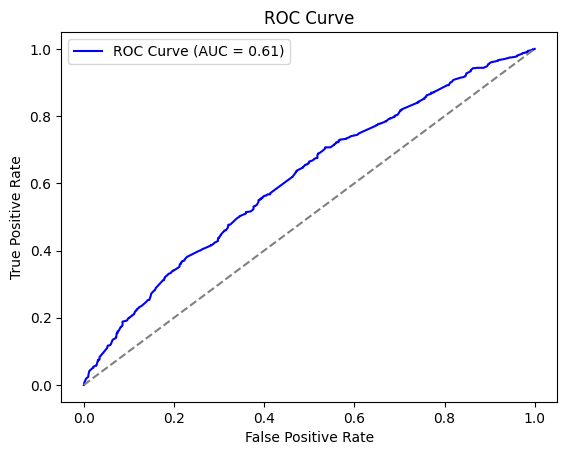

In [17]:
model = best_models["RFC"]
# Get probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

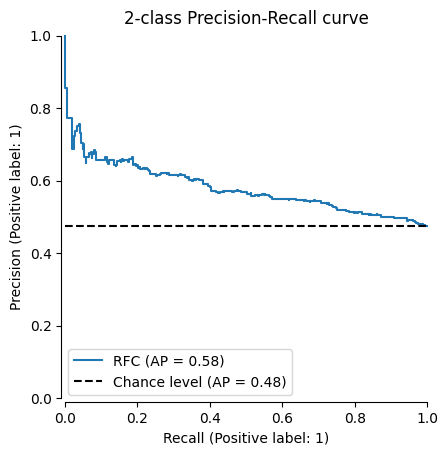

In [18]:
display = PrecisionRecallDisplay.from_estimator(
    best_models["RFC"], X_test, y_test, name="RFC", plot_chance_level=True, despine=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [19]:
def plot_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted Answer Type")
    plt.ylabel("Actual Answer Type")
    plt.title("Confusion Matrix")
    plt.show()

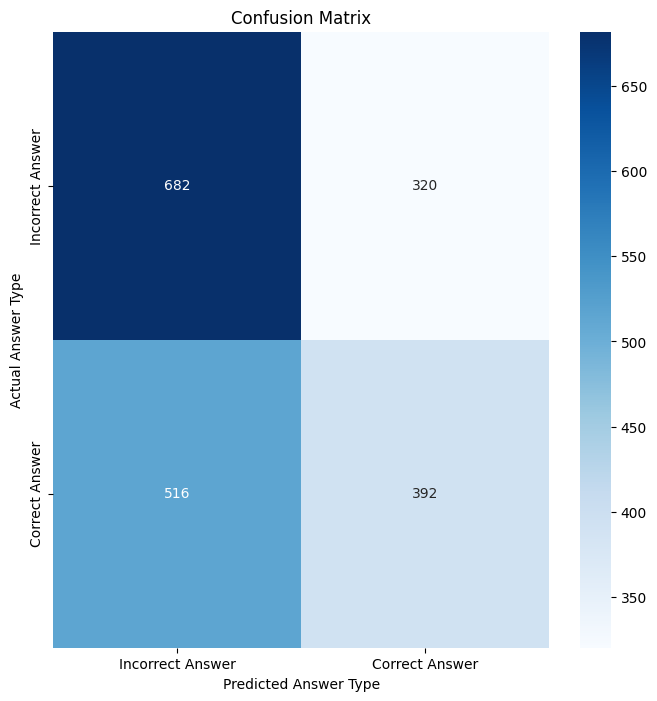

In [20]:
y_preds = cross_val_predict(model, X_test, y_test)
plot_confusion_matrix(y_test, y_preds, ["Incorrect Answer", "Correct Answer"])

### Observations from the Plots:
- The ROC-AUC curve gives a AUC value of 0.61, which states that the model is doing moderate to good on prediction, but not the best since in terms of AUC values, >=0.8 are more significant.
- The RFR's Average Precision (AP) is well above the Chance level AP at 0.58, indicating that the model is performing modest but surely, not good.
- Possible ways to improve the results could be additional feature engineering.
- The Confusion Matrix shows that the model is performing similar on both classes, indicating that the model is more into a "Guessing" state. Although, given the intense dimensionality of the features, this is expected.

### Comparative Analysis: Decision Tree Classifier v/s Logistic Regression

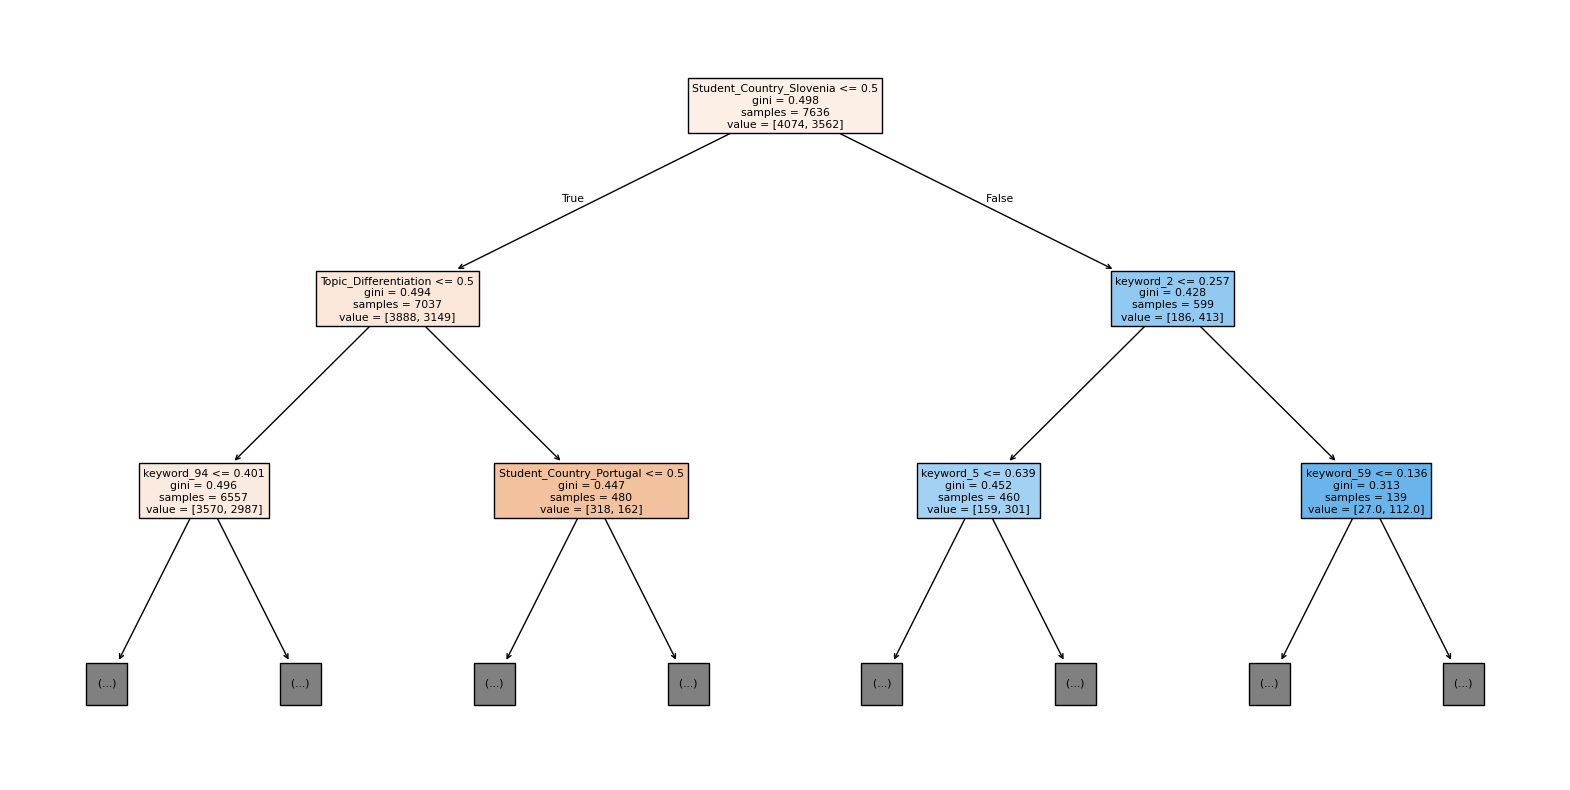

In [21]:
dt = best_models["DecisionTree"]
feature_columns = list(X.columns)
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=feature_columns, filled=True, max_depth=2)
plt.show()

In [22]:
importances = dt.feature_importances_
features_used = []
for name, importance in zip(feature_columns, importances):
    if importance > 0:
        print(f"{name}: {importance:.4f}", end=", ")
        features_used.append(name)
print("\n-------------------------------------------------------")
print("-------------------------------------------------------")
print(f"Total number of features used: {len(features_used)}")

Question_Level_Advanced: 0.0314, Question_Level_Basic: 0.0030, Topic_Differentiation: 0.0412, Topic_Linear_Algebra: 0.0488, Subtopic_Analytic_Geometry: 0.0019, Subtopic_Eigenvalues_and_Eigenvectors: 0.0079, Subtopic_Elementary_Geometry: 0.0311, Subtopic_Limits_and_Continuity: 0.0004, Subtopic_Linear_Transformations: 0.0227, Subtopic_Partial_Differentiation: 0.0037, Subtopic_Probability_: 0.0054, Subtopic_Set_Theory: 0.0151, Subtopic_Statistics: 0.0099, Subtopic_Vector_Spaces: 0.0124, Student_Country_Ireland: 0.0087, Student_Country_Italy: 0.0436, Student_Country_Lithuania: 0.0645, Student_Country_Portugal: 0.1003, Student_Country_Romania: 0.0065, Student_Country_Slovenia: 0.2138, keyword_2: 0.0162, keyword_5: 0.0165, keyword_6: 0.0078, keyword_7: 0.0057, keyword_8: 0.0036, keyword_10: 0.0116, keyword_13: 0.0003, keyword_14: 0.0011, keyword_15: 0.0243, keyword_19: 0.0055, keyword_20: 0.0077, keyword_22: 0.0286, keyword_27: 0.0007, keyword_28: 0.0058, keyword_29: 0.0129, keyword_36: 0.00

In [23]:
lr = best_models["LogisticRegression"]
weights = lr.coef_[0]
bias = lr.intercept_[0]

equation = "logit(P) = {:.3f} + ".format(bias) + " + ".join(
    ["{:.3f} * x{}".format(w, i) for i, w in enumerate(weights, start=1) if w!=0]
)
features_used = [feature_columns[i] for i, w in enumerate(weights, start=0) if w!=0]
print(features_used)
print("----------------------------")
print(f"Total features used: {len(features_used)}")
print("----------------------------")
print(equation)

['Question_Level_Advanced', 'Question_Level_Basic', 'Topic_Analytic_Geometry', 'Topic_Differential_Equations', 'Topic_Differentiation', 'Topic_Numerical_Methods', 'Topic_Real_Functions_of_a_single_variable', 'Topic_Statistics', 'Subtopic_Algebraic_expressions', 'Subtopic_Analytic_Geometry', 'Subtopic_Definite_Integrals', 'Subtopic_Differential_Equations', 'Subtopic_Elementary_Geometry', 'Subtopic_Equations', 'Subtopic_Graph_Theory', 'Subtopic_Integration_Techniques', 'Subtopic_Linear_Optimization', 'Subtopic_Linear_Systems', 'Subtopic_Linear_Transformations', 'Subtopic_Matrices_and_Determinants', 'Subtopic_Numerical_Methods', 'Subtopic_Partial_Differentiation', 'Subtopic_Set_Theory', 'Subtopic_Statistics', 'Subtopic_Vector_Spaces', 'Subtopic_and_Inequalities', 'Student_Country_Ireland', 'Student_Country_Lithuania', 'Student_Country_Portugal', 'Student_Country_Romania', 'Student_Country_Russian_Federation', 'Student_Country_Slovenia', 'Student_Country_Spain', 'keyword_3', 'keyword_4', '

## Trying PCA to reduce dimensionality, since we have 151 features

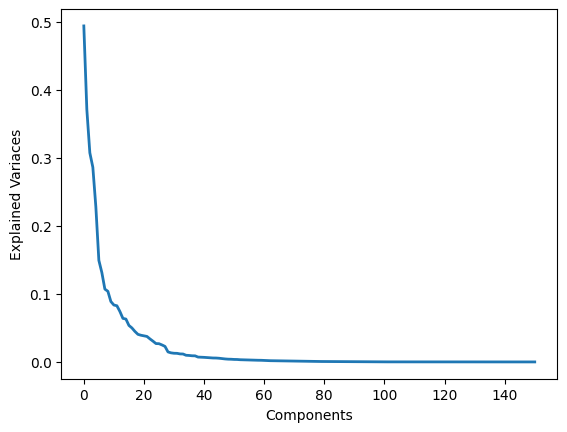

In [24]:
pca2 = PCA().fit(X)
plot(pca2.explained_variance_, linewidth=2)
xlabel('Components')
ylabel('Explained Variaces')
plt.show()

At around 20 components, the PCA curve starts to stabilize. So, we'll use 20 components.

In [25]:
pca = PCA(n_components=20)
X_reduced = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [26]:
classifiers, param_grids = get_classifiers_with_param_grids()
best_models = {}
best_scores = {}

for name, model in classifiers.items():
    print(f"Optimizing {name}...")
    
    search = GridSearchCV(model, param_grids[name], scoring="accuracy", n_jobs=-1)
    search.fit(X_train, y_train)

    best_models[name] = search.best_estimator_
    best_scores[name] = search.best_score_

    print(f"Best Parameters for {name}: {search.best_params_}")
    print(f"Best Model Accuracy: {search.best_score_:.4f}\n")

Optimizing LogisticRegression...
Best Parameters for LogisticRegression: {'C': 0.1, 'penalty': 'l2'}
Best Model Accuracy: 0.5773

Optimizing NaiveBayes...
Best Parameters for NaiveBayes: {'var_smoothing': 0.001}
Best Model Accuracy: 0.5378

Optimizing DecisionTree...
Best Parameters for DecisionTree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best Model Accuracy: 0.5887

Optimizing KNN...
Best Parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 145, 'weights': 'uniform'}
Best Model Accuracy: 0.5919

Optimizing SVM...
Best Parameters for SVM: {'C': 100, 'kernel': 'rbf'}
Best Model Accuracy: 0.5995

Optimizing RFC...
Best Parameters for RFC: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best Model Accuracy: 0.5969



In [27]:
evaluate_models(best_models, X_test, y_test)

           Classifier  Accuracy  F1_Weighted  F1_Macro   ROC_AUC
0  LogisticRegression  0.553403     0.539638  0.535098  0.556880
1          NaiveBayes  0.552880     0.551031  0.548962  0.563481
2        DecisionTree  0.548168     0.532596  0.527766  0.539084
3                 KNN  0.557592     0.513899  0.506046  0.537934
4                 SVM  0.563874     0.557911  0.554779  0.561974
5                 RFC  0.565445     0.554706  0.550701  0.573670


As we can observe, while the ROC_AUC performance for RFR has increased by 0.02, it's still not a significant boost. This suggests that the problem can be further solved using other Non-linear or more complex models such as Neural Networks, where the dimensionality is not much of an issue to have a strong discriminative property.